<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
# !conda activate cs685

In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [7]:
# !git status

install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt

     |████████████████████████████████| 4.2 MB 25.9 MB/s 
     |████████████████████████████████| 1.8 MB 57.9 MB/s 
     |████████████████████████████████| 84 kB 4.3 MB/s 
     |████████████████████████████████| 6.6 MB 60.8 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 145 kB 71.2 MB/s 
     |████████████████████████████████| 181 kB 75.7 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0556151f9b302fe388e044348e5ef88eda0dbdd78746a256507069b07b4b99e7
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [11]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [12]:

data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [13]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [14]:
# Stage 1 Annotations: see config.py for dataset specs
implicit_hate_dataset = Stage1Dataset(dataset_filename["stage-1"], merge_hate_labels=True)

dataset_size = len(implicit_hate_dataset)
dataset_splits = [int(0.6*dataset_size), int(0.2*dataset_size), dataset_size - int(0.6*dataset_size) - int(0.2*dataset_size)]

# # Smaller dataset for testing model
# dataset_splits = [int(0.006*dataset_size), int(0.002*dataset_size), int(0.002*dataset_size)]
print("Dataset size", dataset_size)
print("Dataset splits", dataset_splits)

train_set, val_set, test_set = torch.utils.data.random_split(implicit_hate_dataset, dataset_splits)

train_dataloader =  DataLoader(train_set, batch_size=8, shuffle=False)
validation_dataloader = DataLoader(val_set, batch_size=8, shuffle=False)

# assert len(train_set) == int(0.6*dataset_size)
# assert len(val_set) == int(0.2*dataset_size)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Dataset size 21480
Dataset splits [12888, 4296, 4296]


In [15]:
# Confirming type is tensor
_, _, input_ids, attention_masks, labels = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_set, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    validation_dataloader = DataLoader(val_set, batch_size=config["batch_size"], shuffle=True)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[2]
      input_mask_tensors = batch[3]
      label_tensors = batch[4]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    final_score = precision_recall_fscore_support(predicted, labels, average='binary')
    class_names=['not_hate', 'hate']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [17]:
!wandb login 

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_hate_vs_non_hate",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5, 4e-5]
        },
        "random_seed" : {
          "values": [37, 69, 42]    
        },

        "epochs" : {
            "values" : [4]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="cs685-project")
# sweep_id = "gwbynpx8"

Create sweep with ID: th56riw5
Sweep URL: https://wandb.ai/umass-iesl-is/cs685-project/sweeps/th56riw5


In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader =  DataLoader(train_set, batch_size=config["batch_size"], shuffle=False)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[2]
                input_mask_tensors = batch[3]
                label_tensors = batch[4]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_set, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'implicit_hate_detection_hate_vs_non_hate_seed.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_set, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: paw0l8x7 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37
wandb: Currently logged in as: psarda (umass-iesl-is). Use `wandb login --relogin` to force relogin


Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 858.9388964027166


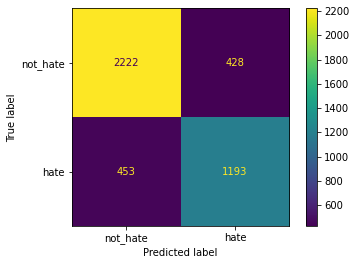

0.7247873633049817 0.7359654534238125 0.7303336394245485
Validation accuracy: 0.7949255121042831

======== Epoch 2 / 4 ========
Training...
Total loss: 614.8965575397015


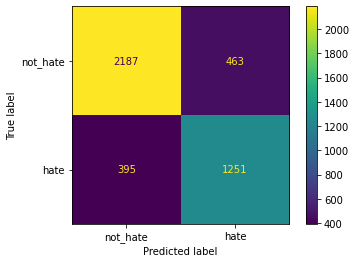

0.7600243013365735 0.7298716452742123 0.7446428571428572
Validation accuracy: 0.8002793296089385

======== Epoch 3 / 4 ========
Training...
Total loss: 400.4546918477863


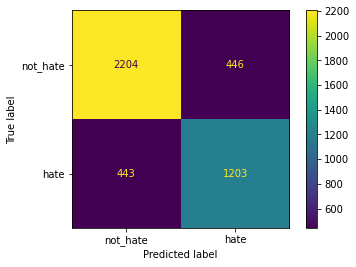

0.7308626974483596 0.7295330503335354 0.7301972685887709
Validation accuracy: 0.7930633147113594

======== Epoch 4 / 4 ========
Training...
Total loss: 252.42083129659295


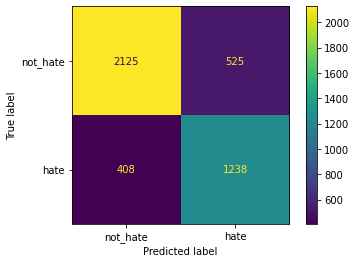

0.7521263669501823 0.7022121384004538 0.7263127016720446
Validation accuracy: 0.7828212290502793

Training complete!


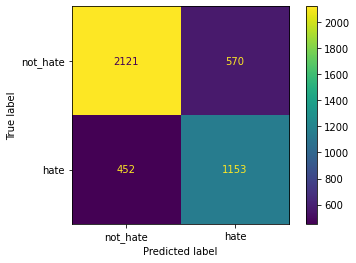

0.7183800623052959 0.669181659895531 0.6929086538461539
Test accuracy: 0.7621042830540037


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▅▃▆▃▄▄▅▃▃▂▆▂▄▂▃▂▄▄▂▁▅▂▂▂▁▁▆▂█▁▁▂▁▃▂▃▄▂
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▆█▅▁
val_f1,▃█▂▁
val_precision,▁█▂▆


wandb: Agent Starting Run: zw0e7rwl with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 839.2942398041487


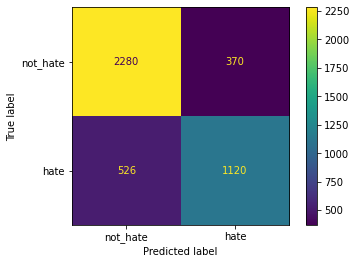

0.6804374240583232 0.7516778523489933 0.7142857142857142
Validation accuracy: 0.7914338919925512

======== Epoch 2 / 4 ========
Training...
Total loss: 592.4691401347518


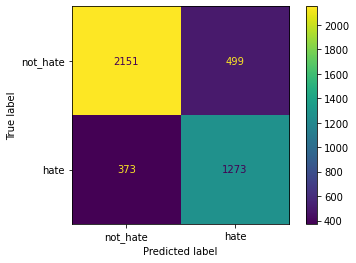

0.7733900364520049 0.7183972911963883 0.7448800468110006
Validation accuracy: 0.7970204841713222

======== Epoch 3 / 4 ========
Training...
Total loss: 379.7935282038525


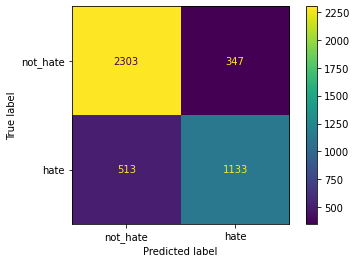

0.6883353584447145 0.7655405405405405 0.7248880358285349
Validation accuracy: 0.7998137802607076

======== Epoch 4 / 4 ========
Training...
Total loss: 218.4685133304447


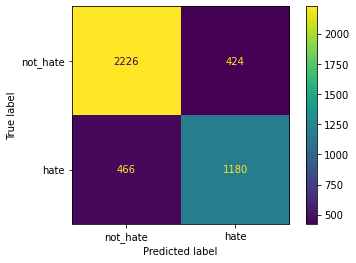

0.7168894289185905 0.7356608478802993 0.7261538461538461
Validation accuracy: 0.792830540037244

Training complete!


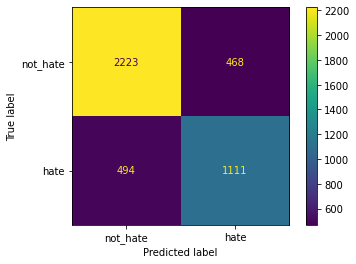

0.6922118380062305 0.7036098796706777 0.6978643216080402
Test accuracy: 0.7760707635009311


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▇▆▅▄▆▅▅▅▇▄▄▃▇▂▅▅▂▅▄▄▂▂▇▁▂▂▂▂█▃█▁▁▃▁▂▁▂▄▂
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▆█▂
val_f1,▁█▃▄
val_precision,▁█▂▄


wandb: Agent Starting Run: na8ufax5 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 846.4940043389797


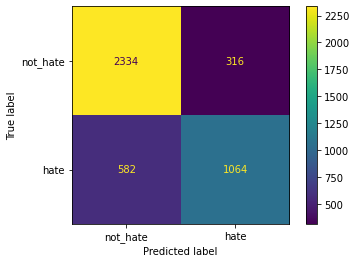

0.6464155528554071 0.7710144927536232 0.7032385988103106
Validation accuracy: 0.7909683426443203

======== Epoch 2 / 4 ========
Training...
Total loss: 592.1494412086904


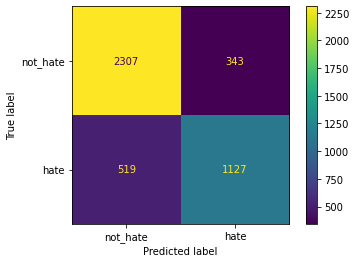

0.6846901579586877 0.7666666666666667 0.7233632862644416
Validation accuracy: 0.7993482309124768

======== Epoch 3 / 4 ========
Training...
Total loss: 374.6754759307951


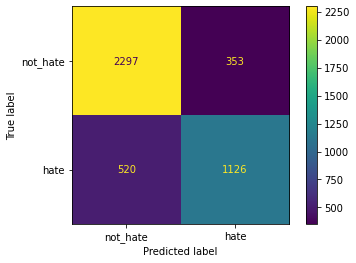

0.68408262454435 0.7613252197430697 0.7206400000000001
Validation accuracy: 0.7967877094972067

======== Epoch 4 / 4 ========
Training...
Total loss: 222.6634055026807


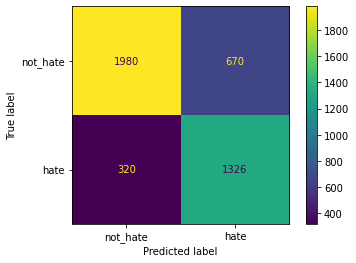

0.8055893074119077 0.6643286573146293 0.728171334431631
Validation accuracy: 0.7695530726256983

Training complete!


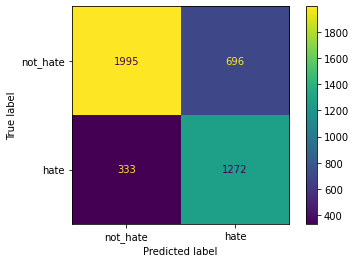

0.7925233644859813 0.6463414634146342 0.7120067170445005
Test accuracy: 0.7604748603351955


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▅▅▅█▅▅▄▆▄▄▃▅▂▅▄▂▄▄▄▂▂▆▁▂▂▁▂▆▂▆▁▁▁▂▅▃▁▃▃
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▆█▇▁
val_f1,▁▇▆█
val_precision,▁▃▃█


wandb: Agent Starting Run: alkrspzq with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 842.5248530507088


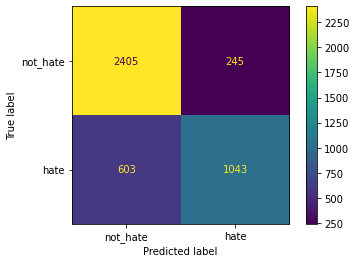

0.6336573511543135 0.8097826086956522 0.7109747784594411
Validation accuracy: 0.8026070763500931

======== Epoch 2 / 4 ========
Training...
Total loss: 565.5633585024625


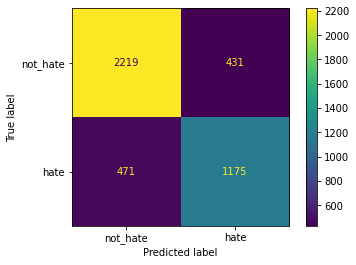

0.7138517618469016 0.7316313823163139 0.7226322263222632
Validation accuracy: 0.7900372439478585

======== Epoch 3 / 4 ========
Training...
Total loss: 334.65120341652073


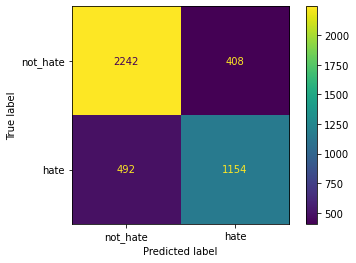

0.701093560145808 0.7387964148527529 0.7194513715710723
Validation accuracy: 0.7905027932960894

======== Epoch 4 / 4 ========
Training...
Total loss: 197.23449631675612


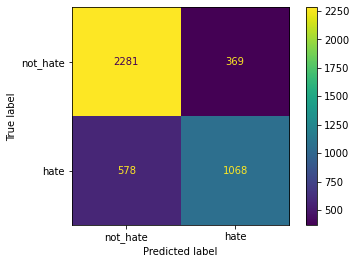

0.6488456865127582 0.7432150313152401 0.692831657476484
Validation accuracy: 0.779562383612663

Training complete!


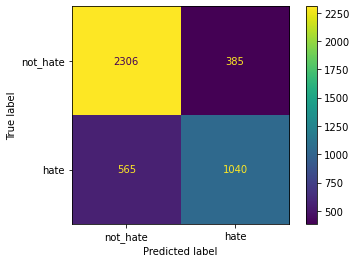

0.6479750778816199 0.7298245614035088 0.6864686468646864
Test accuracy: 0.7788640595903166


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▄▃▄▄▃▃▄▃▃▂▄▂▅▃▂▃▃▃▂▂▅▁▂▂▁▂█▂▃▄▁▂▁▁▁▂▁▄
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▄▄▁
val_f1,▅█▇▁
val_precision,▁█▇▂


wandb: Agent Starting Run: zvc6jcws with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 818.7416438907385


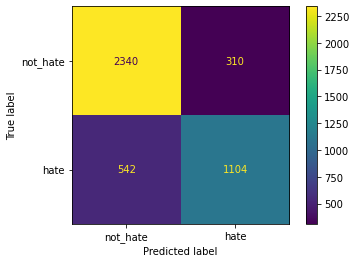

0.6707168894289186 0.7807637906647807 0.7215686274509805
Validation accuracy: 0.8016759776536313

======== Epoch 2 / 4 ========
Training...
Total loss: 543.6969543416053


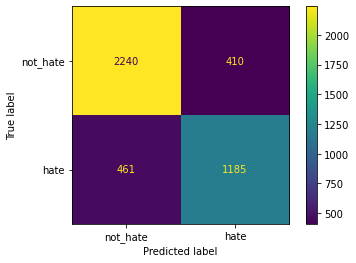

0.7199270959902795 0.7429467084639498 0.7312557852514655
Validation accuracy: 0.7972532588454376

======== Epoch 3 / 4 ========
Training...
Total loss: 303.2111472750548


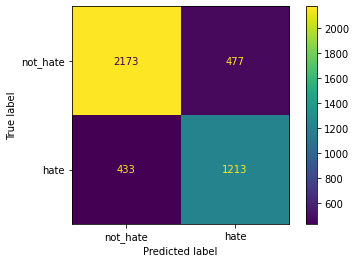

0.7369380315917375 0.7177514792899409 0.7272182254196643
Validation accuracy: 0.7881750465549349

======== Epoch 4 / 4 ========
Training...
Total loss: 174.90184603841044


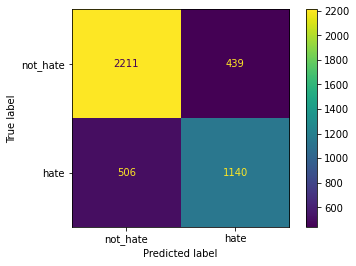

0.692588092345079 0.7219759341355289 0.7069767441860466
Validation accuracy: 0.7800279329608939

Training complete!


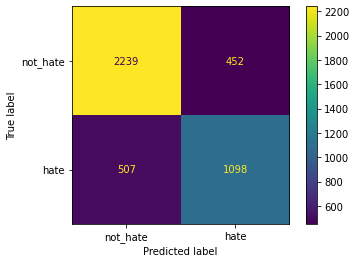

0.6841121495327103 0.7083870967741935 0.6960380348652933
Test accuracy: 0.7767690875232774


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▇▆▆▅▇▅▅▅▆▄▄▃▃▃▆▅▃▄▅▄▂▁█▁▁▂▁▁█▁▇▁▂▂▁▂▁▂▁▃
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▇▄▁
val_f1,▅█▇▁
val_precision,▁▆█▃


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: e6nzdl10 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 819.0961729884148


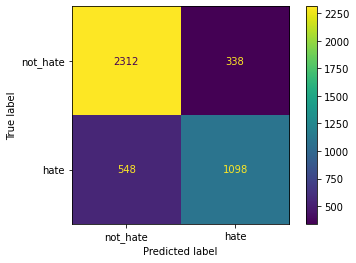

0.6670716889428918 0.7646239554317549 0.7125243348475017
Validation accuracy: 0.7937616387337058

======== Epoch 2 / 4 ========
Training...
Total loss: 556.9123672228307


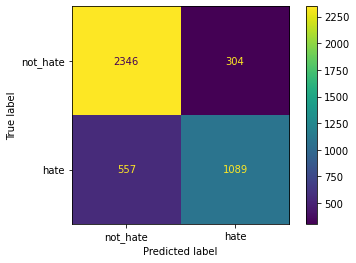

0.6616038882138517 0.7817659727207465 0.7166831194471865
Validation accuracy: 0.7995810055865922

======== Epoch 3 / 4 ========
Training...
Total loss: 311.26870474778116


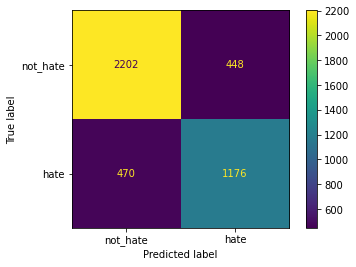

0.7144592952612394 0.7241379310344828 0.7192660550458716
Validation accuracy: 0.7863128491620112

======== Epoch 4 / 4 ========
Training...
Total loss: 179.2681626570411


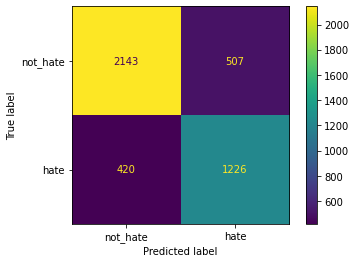

0.7448359659781288 0.7074437391806117 0.7256584788398934
Validation accuracy: 0.784217877094972

Training complete!


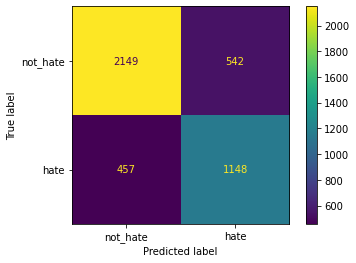

0.7152647975077882 0.6792899408284023 0.696813353566009
Test accuracy: 0.7674581005586593


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▆▆▅▄█▅▅▄▇▄▄▂▄▄▅▄▃▃▄▄▂▁▇▂▁▂▁▁█▂▂▁▁▄▁▁▁▁▁▁
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▅█▂▁
val_f1,▁▃▅█
val_precision,▁▁▅█


wandb: Agent Starting Run: 67pztug2 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 836.5321918725967


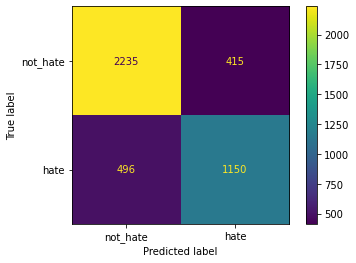

0.6986634264884569 0.7348242811501597 0.7162877608221739
Validation accuracy: 0.7879422718808193

======== Epoch 2 / 4 ========
Training...
Total loss: 555.8408526871353


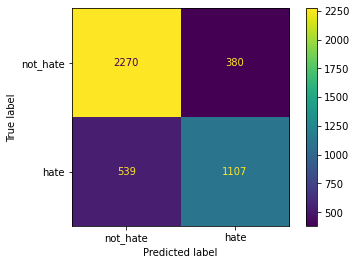

0.672539489671932 0.7444519166106254 0.7066709224385573
Validation accuracy: 0.7860800744878957

======== Epoch 3 / 4 ========
Training...
Total loss: 316.30126627755817


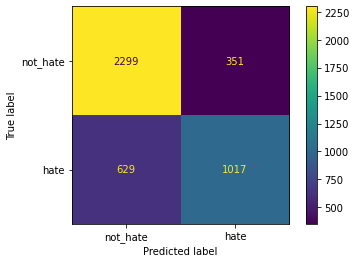

0.6178614823815309 0.743421052631579 0.674850696748507
Validation accuracy: 0.7718808193668529

======== Epoch 4 / 4 ========
Training...
Total loss: 188.49377296719467


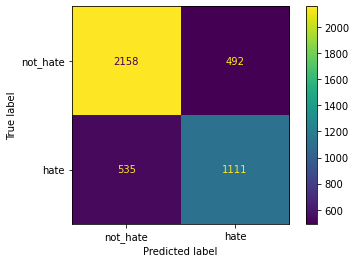

0.6749696233292831 0.6930754834684966 0.6839027393044014
Validation accuracy: 0.7609404096834265

Training complete!


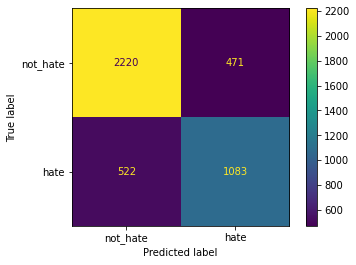

0.6747663551401869 0.696911196911197 0.6856600189933524
Test accuracy: 0.7688547486033519


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▄▄▅▃▃▄▄▄▃▂▄▂▄▃▂▃▃▂▂▂▆▁▁▃▁▁█▂▃▂▁▃▁▁▁▁▁▂
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,██▄▁
val_f1,█▆▁▃
val_precision,█▆▁▆


wandb: Agent Starting Run: abw6xwpb with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 815.7049238756299


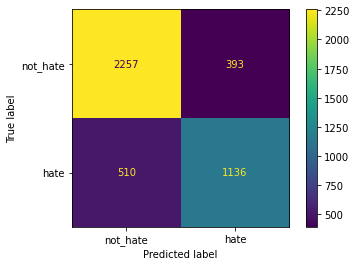

0.6901579586877278 0.7429692609548725 0.7155905511811024
Validation accuracy: 0.789804469273743

======== Epoch 2 / 4 ========
Training...
Total loss: 536.418051507324


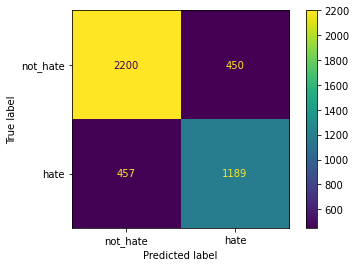

0.7223572296476306 0.7254423428920074 0.723896499238965
Validation accuracy: 0.7888733705772812

======== Epoch 3 / 4 ========
Training...
Total loss: 288.8477017339319


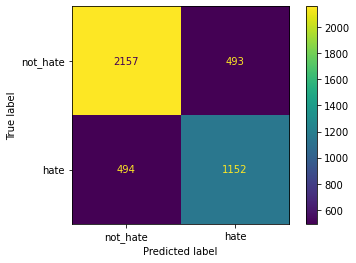

0.6998784933171325 0.7003039513677811 0.7000911577028259
Validation accuracy: 0.7702513966480447

======== Epoch 4 / 4 ========
Training...
Total loss: 173.62644598260522


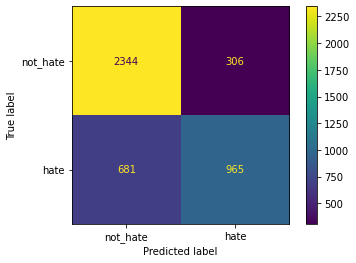

0.586269744835966 0.7592446892210858 0.6616386698663009
Validation accuracy: 0.7702513966480447

Training complete!


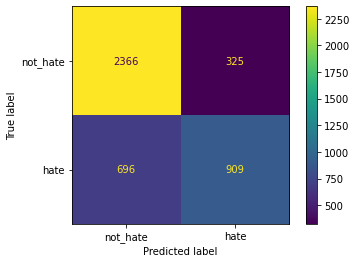

0.5663551401869159 0.7366288492706645 0.640366326171187
Test accuracy: 0.7623370577281192


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▄▄▆▄▄▄▄▄▃▂▃▂▅▃▂▂▄▂▂▁▂▁▁▃▁▁█▁▂▁▃▄▁▃▁▁▁▂
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,██▁▁
val_f1,▇█▅▁
val_precision,▆█▇▁


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: np82239d with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 820.2502704784274


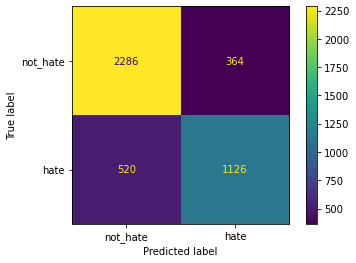

0.68408262454435 0.7557046979865771 0.7181122448979592
Validation accuracy: 0.7942271880819367

======== Epoch 2 / 4 ========
Training...
Total loss: 549.2680387459695


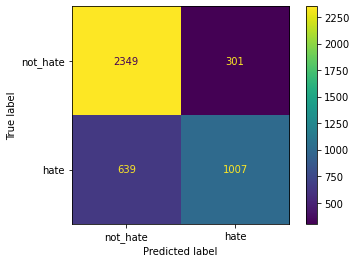

0.6117861482381531 0.7698776758409785 0.6817874069058903
Validation accuracy: 0.7811918063314711

======== Epoch 3 / 4 ========
Training...
Total loss: 312.57518207933754


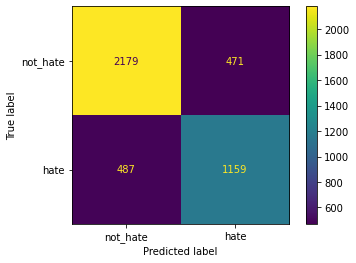

0.704131227217497 0.7110429447852761 0.7075702075702076
Validation accuracy: 0.777001862197393

======== Epoch 4 / 4 ========
Training...
Total loss: 183.49081550270785


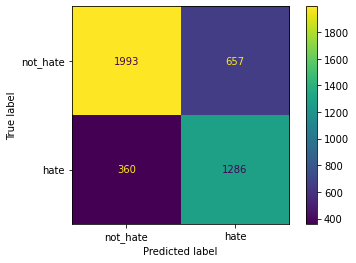

0.7812879708383961 0.6618630983015955 0.7166341599331291
Validation accuracy: 0.763268156424581

Training complete!


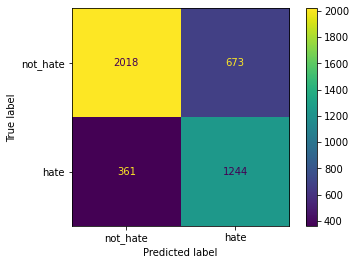

0.7750778816199377 0.6489306207616067 0.7064168086314594
Test accuracy: 0.7593109869646183


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▄▄▆▄▃▃▅▃▄▂▄▂▄▃▂▃▄▃▂▁▄▁▁▂▁▃█▂▃▁▅▂▁▁▁▁▁▂
epoch,▁▁▁▁
loss,█▅▂▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▅▄▁
val_f1,█▁▆█
val_precision,▄▁▅█


wandb: Agent Starting Run: 8fmw03zu with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 866.6300205662847


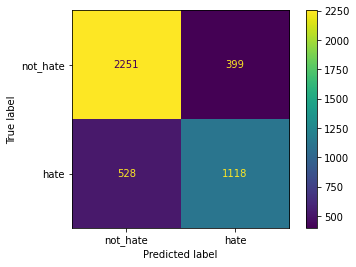

0.6792223572296476 0.7369808833223468 0.7069238065128043
Validation accuracy: 0.784217877094972

======== Epoch 2 / 4 ========
Training...
Total loss: 625.4286356139928


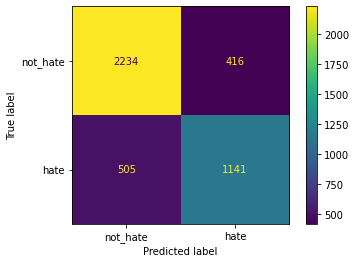

0.6931956257594167 0.7328195247270392 0.712457071495473
Validation accuracy: 0.7856145251396648

======== Epoch 3 / 4 ========
Training...
Total loss: 403.49498108192347


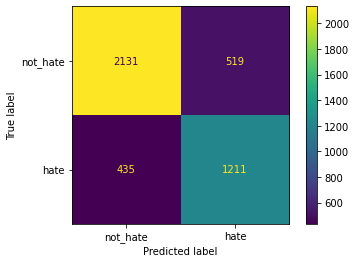

0.735722964763062 0.7 0.7174170616113743
Validation accuracy: 0.7779329608938548

======== Epoch 4 / 4 ========
Training...
Total loss: 255.94205132836942


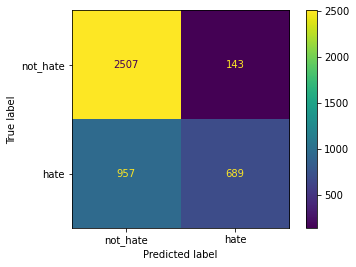

0.41859052247873635 0.828125 0.5560936238902341
Validation accuracy: 0.7439478584729982

Training complete!


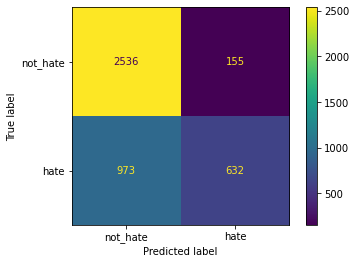

0.39376947040498445 0.8030495552731893 0.5284280936454849
Test accuracy: 0.7374301675977654


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▅▄▆▃▄▃▅▄▃▃▄▂▄▃▃▂▄▃▂▁▆▁▂▃▁▂█▂▃▃▂▁▂▁▁▁▁▂
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,██▇▁
val_f1,███▁
val_precision,▇▇█▁


wandb: Agent Starting Run: o8um8kl3 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 822.5958143398166


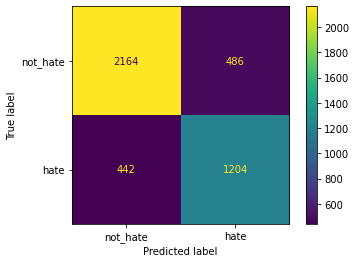

0.7314702308626975 0.7124260355029586 0.7218225419664269
Validation accuracy: 0.7839851024208566

======== Epoch 2 / 4 ========
Training...
Total loss: 562.4874362293631


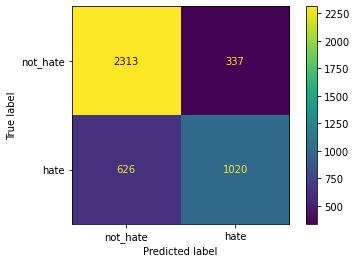

0.6196840826245443 0.7516580692704495 0.6793206793206794
Validation accuracy: 0.7758379888268156

======== Epoch 3 / 4 ========
Training...
Total loss: 345.4635966734495


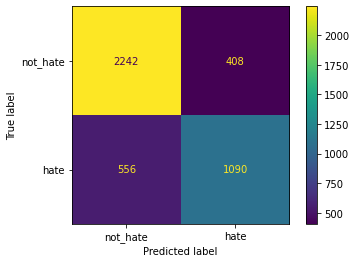

0.6622114216281896 0.7276368491321762 0.693384223918575
Validation accuracy: 0.7756052141527002

======== Epoch 4 / 4 ========
Training...
Total loss: 207.84719645697623


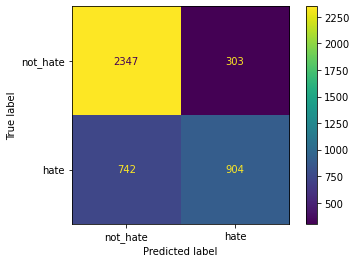

0.5492102065613609 0.7489643744821872 0.6337188923939713
Validation accuracy: 0.7567504655493482

Training complete!


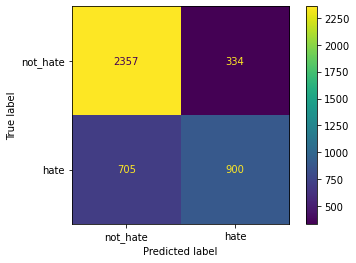

0.5607476635514018 0.7293354943273906 0.6340260655160268
Test accuracy: 0.758147113594041


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▅▄▄▄▆▃▄▃▄▃▃▂▂▂▃▃▂▂▃▂▃▂▃▁▃▂▁▁█▁▄▁▂▁▄▂▁▁▃▁
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,█▆▆▁
val_f1,█▅▆▁
val_precision,█▄▅▁


wandb: Agent Starting Run: xm4svp25 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 4
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at


======== Epoch 1 / 4 ========
Training...
Total loss: 847.6033752858639


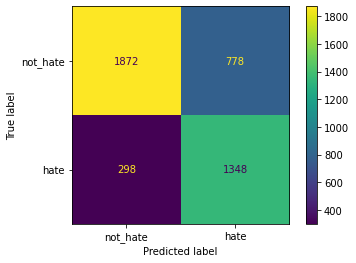

0.818955042527339 0.6340545625587959 0.7147401908801697
Validation accuracy: 0.749534450651769

======== Epoch 2 / 4 ========
Training...
Total loss: 606.0574038410559


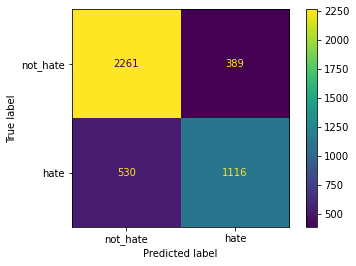

0.6780072904009721 0.7415282392026578 0.708346556648683
Validation accuracy: 0.7860800744878957

======== Epoch 3 / 4 ========
Training...
Total loss: 418.3594261724502


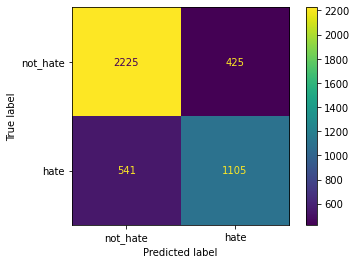

0.6713244228432563 0.7222222222222222 0.6958438287153652
Validation accuracy: 0.7751396648044693

======== Epoch 4 / 4 ========
Training...
Total loss: 287.39910796051845


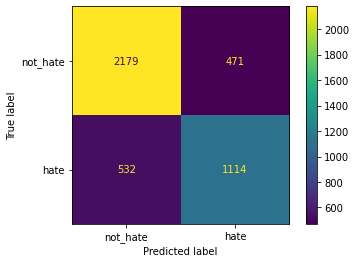

0.6767922235722965 0.7028391167192429 0.6895697926338595
Validation accuracy: 0.7665270018621974

Training complete!


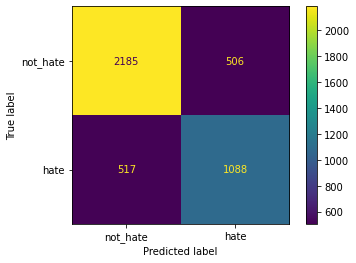

0.6778816199376947 0.6825595984943539 0.6802125664270084
Test accuracy: 0.7618715083798883


batch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▅▆▇█▁▂▂▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█
batch_loss,▄▄▄▄▆▃▄▃▅▃▄▂▄▂▄▃▂▂▄▃▂▁▄▁▂▂▁▂█▂▂▁▁▂▅▁▁▁▁▃
epoch,▁▁▁▁
loss,█▅▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▆▄
val_f1,█▆▃▁
val_precision,█▁▁▁


In [20]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="cs685-project")